In [4]:
%matplotlib inline

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
X_data = np.load('Sign-language-digits-dataset/X.npy')
Y_data = np.load('Sign-language-digits-dataset/Y.npy')

(410, 64, 64)
(410, 1)


(-0.5, 63.5, 63.5, -0.5)

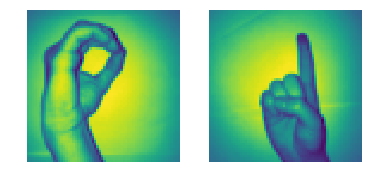

In [7]:
X_zeros = X_data[204:409]
X_ones = X_data[822:1027]

Y_zeros = np.zeros(205)
Y_ones = np.ones(205)

X = np.concatenate((X_zeros, X_ones), axis=0)
Y = np.concatenate((Y_zeros, Y_ones), axis=0).reshape(X.shape[0], 1)

print(X.shape)
print(Y.shape)

plt.subplot(1, 2, 1)
plt.imshow(X_zeros[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_ones[0])
plt.axis('off')

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

X_train = X_train.reshape(number_of_train, X_train.shape[1]*X_train.shape[2]).T
X_test = X_test.reshape(number_of_test, X_test.shape[1]*X_test.shape[2]).T
Y_train = Y_train.T
Y_test = Y_test.T

print("x train: ", X_train.shape)
print("x test: ", X_test.shape)
print("y train: ", Y_train.shape)
print("y test: ", Y_test.shape)

x train:  (4096, 348)
x test:  (4096, 62)
y train:  (1, 348)
y test:  (1, 62)


1) Датасет - изображения цифр 0 и 1 на языке жестов
2) Задача нейросети - предсказать цифру, изображенную на поданном изображении
3) Нейронная сеть с двумя слоями, в 1 слое 3 нейрона, во 2 слое - 1 нейрон
4) Функция активации первого слоя - тангенс, функция активации второго - сигмоидальная
5) Для вычисления размера ошибки используется кросс-энтропия

In [18]:
def initialize_parameters_and_layer_sizes_NN(x_train, y_train):
    parameters = {"weight1": np.random.randn(3, x_train.shape[0]) * 0.1, # (3, 4096)
                  "bias1": np.zeros((3, 1)),
                  "weight2": np.random.randn(y_train.shape[0], 3) * 0.1, # (1, 3)
                  "bias2": np.zeros((y_train.shape[0], 1))}
    return parameters

In [10]:
def sigmoid(z):
    Y_head = 1/(1 + np.exp(-z))
    return Y_head

In [11]:
def forward_propagation_NN(x_train, parameters):
    Z1 = np.dot(parameters["weight1"], x_train) + parameters["bias1"] # (3, x_train.shape[1])
    A1 = np.tanh(Z1) # dTanh/dx = 1 - Tanh(x)^2
    Z2 = np.dot(parameters["weight2"], A1) + parameters["bias2"] # (1, x_train.shape[1])
    A2 = sigmoid(Z2) # dSigm/dx = 1*(1 - Sigm(x))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [12]:
def compute_cost_NN(A2, Y, parameters): # cross-entropy dE/dout = -((y1(1/out)) + (i-y1)(1/(1 - out)))
    logprobs = np.multiply(np.log(A2), Y)
    cost = -np.sum(logprobs)/Y.shape[1]
    return cost

In [19]:
def backward_propagation_NN(parameters, cache, X, Y): # dE/dW = dE/dout * dout/din * din/dW
    dZ2 = cache["A2"] - Y # dz = dE/dout * dout/din
    dW2 = np.dot(dZ2, cache["A1"].T)/X.shape[1] # dE/dW = dz * din/dW
    db2 = np.sum(dZ2, axis=1, keepdims=True)/X.shape[1]
    
    dZ1 = np.dot(parameters["weight2"].T, dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1, X.T)/X.shape[1]
    db1 = np.sum(dZ1, axis=1, keepdims=True)/X.shape[1]
    
    grads = {"dweight1": dW1,
             "dbias1": db1,
             "dweight2": dW2,
             "dbias2": db2}
    return grads

In [14]:
def update_parameters_NN(parameters, grads, learning_rate = 0.01):
    parameters = {"weight1": parameters["weight1"] - learning_rate*grads["dweight1"],
                  "bias1": parameters["bias1"] - learning_rate*grads["dbias1"],
                  "weight2": parameters["weight2"] - learning_rate*grads["dweight2"],
                  "bias2": parameters["bias2"] - learning_rate*grads["dbias2"]}
    
    return parameters

In [15]:
def predict_NN(parameters, x_test):
    A2, cache = forward_propagation_NN(x_test, parameters)
    Y_prediction = np.zeros((1, x_test.shape[1]))
    for i in range(A2.shape[1]):
        if A2[0, i]<= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1

    return Y_prediction

In [16]:
def two_layer_neural_network(x_train, y_train, x_test, y_test, num_iterations):
    cost_list = []
    index_list = []
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train)

    for i in range(0, num_iterations):
        A2, cache = forward_propagation_NN(x_train, parameters)
        cost = compute_cost_NN(A2, y_train, parameters)
        grads = backward_propagation_NN(parameters, cache, x_train, y_train)
        parameters = update_parameters_NN(parameters, grads)
        
        if i % 100 == 0:
            cost_list.append(cost)
            index_list.append(i)
            print ("Ошибка после %i итерации: %f" %(i, cost))
    plt.plot(index_list,cost_list)
    plt.xticks(index_list,rotation='vertical')
    plt.xlabel("Итерация")
    plt.ylabel("Ошибка")
    plt.show()
    
    y_prediction_test = predict_NN(parameters,x_test)
    y_prediction_train = predict_NN(parameters,x_train)

    print("Точность на тренировочной выборке: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("Точность на тестовой выборке: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    return parameters

(3, 4096)
(1, 3)
Ошибка после 0 итерации: 0.362785
Ошибка после 100 итерации: 0.341564
Ошибка после 200 итерации: 0.319035
Ошибка после 300 итерации: 0.284048
Ошибка после 400 итерации: 0.241676
Ошибка после 500 итерации: 0.201001
Ошибка после 600 итерации: 0.170591
Ошибка после 700 итерации: 0.144858
Ошибка после 800 итерации: 0.124466
Ошибка после 900 итерации: 0.108596
Ошибка после 1000 итерации: 0.095517
Ошибка после 1100 итерации: 0.082684
Ошибка после 1200 итерации: 0.072379
Ошибка после 1300 итерации: 0.063971
Ошибка после 1400 итерации: 0.057048
Ошибка после 1500 итерации: 0.051217
Ошибка после 1600 итерации: 0.046130
Ошибка после 1700 итерации: 0.041535
Ошибка после 1800 итерации: 0.037450
Ошибка после 1900 итерации: 0.034046
Ошибка после 2000 итерации: 0.031242
Ошибка после 2100 итерации: 0.028869
Ошибка после 2200 итерации: 0.026822
Ошибка после 2300 итерации: 0.025031
Ошибка после 2400 итерации: 0.023452


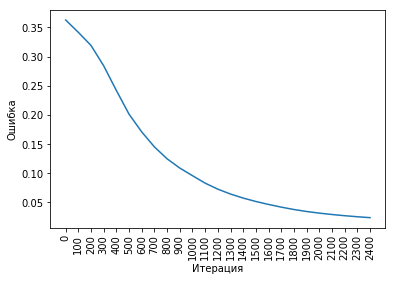

Точность на тренировочной выборке: 100.0 %
Точность на тестовой выборке: 93.54838709677419 %


In [17]:
parameters = two_layer_neural_network(X_train, Y_train, X_test, Y_test, num_iterations=2500)